In [1]:
import os
cwd = os.getcwd().replace('/reinforcement_learning', '')
os.chdir(cwd)

In [2]:
from dataset import Dataset
import gym
import gym_anytrading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
import pandas as pd
import quantstats as qs


In [3]:
data_binance = Dataset().get_data(days=30, ticker='BTCUSDT', ts='5m')

In [4]:
df = data_binance.copy()[['open', 'high', 'low', 'close', 'volume']]
df = df.reset_index()
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.set_index('Date')

In [7]:
log_dir = "/home/serg/projects/youtoube/reinforcement_learning/tmp"
stats_path = os.path.join(log_dir, "vec_normalize.pkl")

window_size = 50
start_index = window_size
end_index = len(df)
num_cpu = os.cpu_count()


def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df,  frame_bound=(start_index,
                   end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)


env = make_vec_env(
    lambda: env_maker(),
    n_envs=num_cpu,
    seed=0,
    vec_env_cls=DummyVecEnv
)

# Automatically normalize the input features and reward
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)


In [8]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard_logs/")
model.learn(total_timesteps=2500000)

Using cuda device
Logging to ./tensorboard_logs/PPO_7
------------------------------
| time/              |       |
|    fps             | 2431  |
|    iterations      | 1     |
|    time_elapsed    | 5     |
|    total_timesteps | 12288 |
------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1584       |
|    iterations           | 2          |
|    time_elapsed         | 15         |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.00821992 |
|    clip_fraction        | 0.083      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.686     |
|    explained_variance   | -0.819     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0568     |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 0.28       |
--------------------------------

In [9]:
model.save(f"{log_dir}/ppo_halfcheetah")
env.save(stats_path)

### Test Model

In [10]:
env = make_vec_env(
    lambda: env_maker(),
    n_envs=num_cpu,
    seed=0,
    vec_env_cls=DummyVecEnv
)
env = VecNormalize.load(stats_path, env)
env.training = False
env.norm_reward = False


# Load the agent
model = PPO.load(f"{log_dir}/ppo_halfcheetah", env=env)

obs = env.reset()
results = []
while True:
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    profit = {f'env_{num}': float(i["total_profit"]) for num, i in enumerate(info)}
    results.append(profit)
    if done.all():
        break
results = pd.DataFrame(results)

<AxesSubplot:>

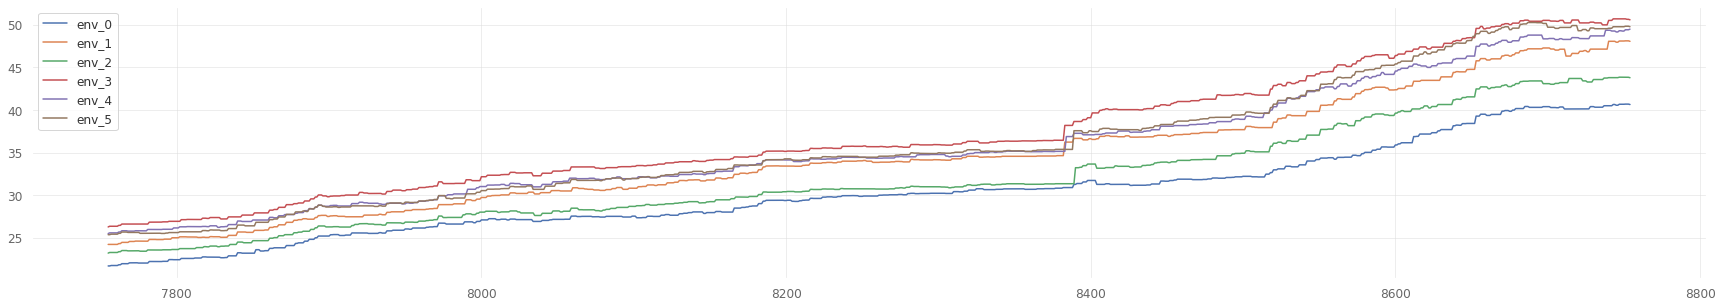

In [12]:
results.tail(1000).plot(figsize=(30, 5))

                           Strategy
-------------------------  -----------------------
Start Period               2022-05-20
End Period                 2022-06-19
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          3,956.02%
CAGR﹪                     3.6746473235764237e+21%

Sharpe                     3.31
Prob. Sharpe Ratio         100.0%
Smart Sharpe               3.17
Sortino                    11.87
Smart Sortino              11.36
Sortino/√2                 8.39
Smart Sortino/√2           8.03
Omega                      5.38

Max Drawdown               -2.34%
Longest DD Days            0
Volatility (ann.)          3.24%
Calmar                     1.5692198793560122e+21
Skew                       5.33
Kurtosis                   46.53

Expected Daily %           0.04%
Expected Monthly %         536.87%
Expected Yearly %          3956.02%
Kelly Criterion            57.62%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.29%
Expect

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-06-15,2022-06-15,2022-06-16,0,-2.341703,-1.941933
2,2022-06-18,2022-06-18,2022-06-18,0,-1.840266,-1.771212
3,2022-05-24,2022-05-25,2022-05-25,0,-1.416277,-1.402605
4,2022-06-14,2022-06-14,2022-06-14,0,-1.283630,-1.236847
5,2022-06-16,2022-06-17,2022-06-17,0,-1.175097,-0.737378


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


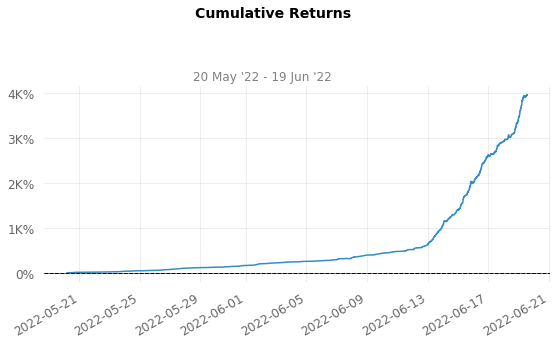

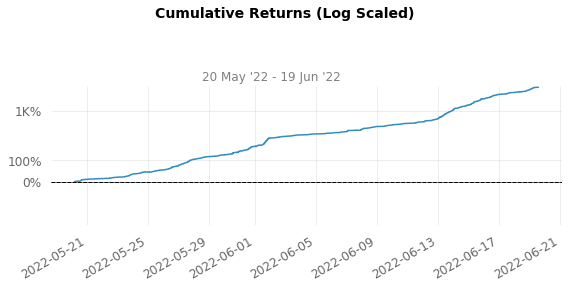

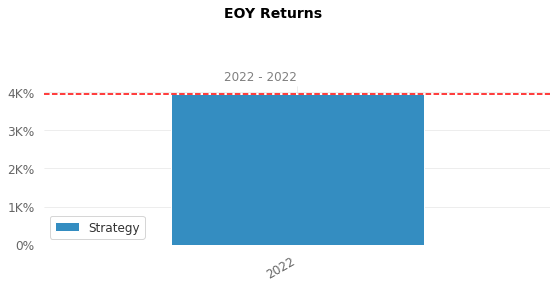

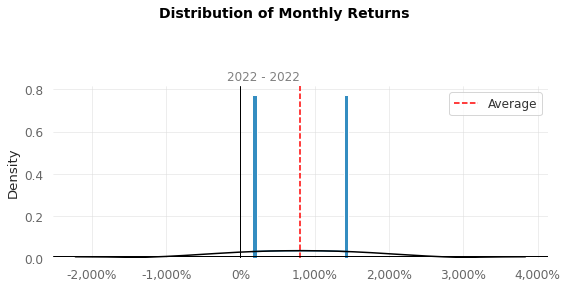

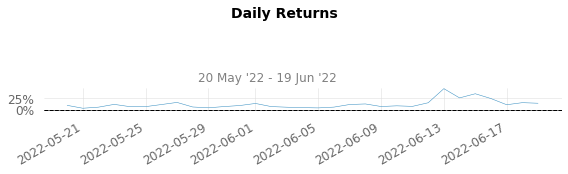

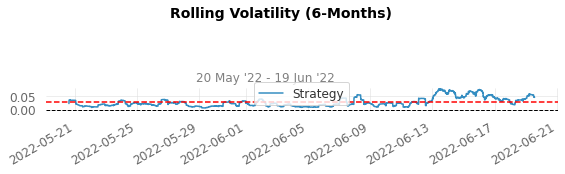

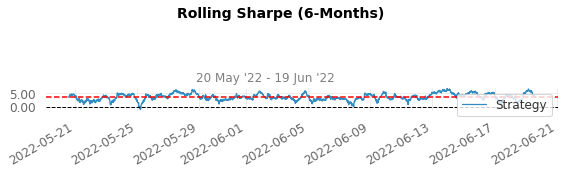

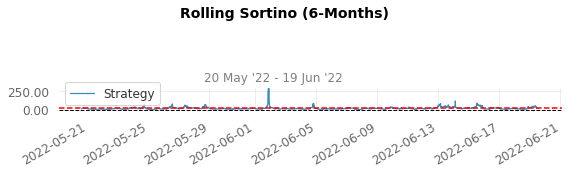

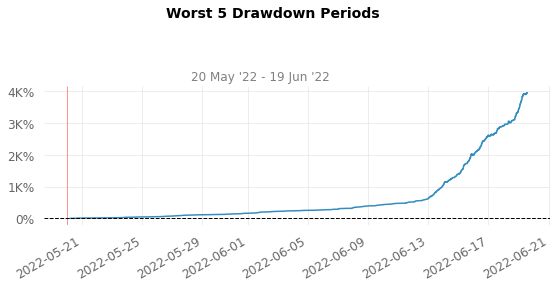

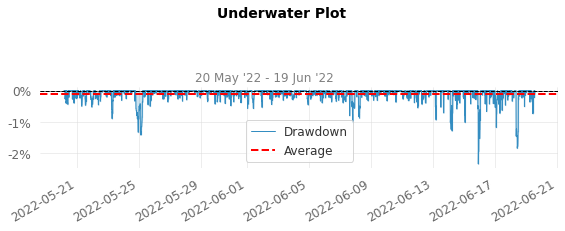

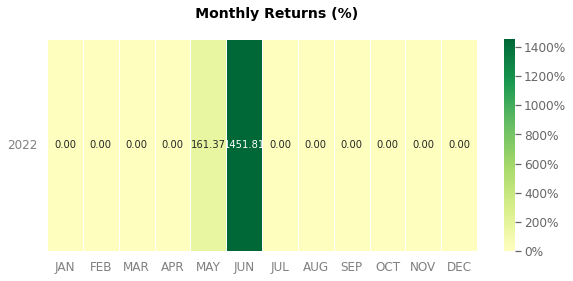

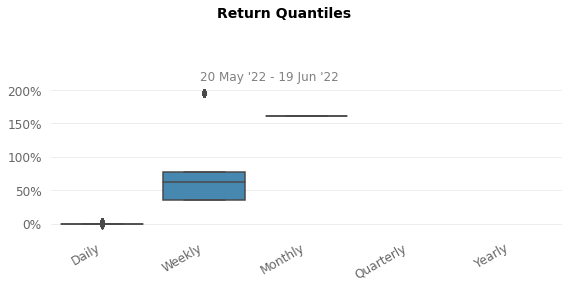

In [13]:
qs.extend_pandas()

net_worth = pd.Series(results['env_0'].values, index=df.index[start_index+1:end_index])
returns = net_worth.iloc[1:]
qs.reports.full(returns)
# qs.reports.html(returns, output='reinforcement_learning/a2c_quantstats.html')


In [30]:
%tensorboard --logdir tensorboard_logs

UsageError: Line magic function `%tensorboard` not found.
